# PCA Anomalies Detection

## Methodology

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
plt.style.use('seaborn')
sns.set_palette("husl")

C:\Users\haoru\AppData\Local\Temp\ipykernel_32532\481652196.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### 1. PCA

In [ ]:
def perform_pca_analysis(returns_data, n_components=100):
    """Standard PCA analysis function"""
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(returns_data)
    
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_data)
    
    explained_variance = pca.explained_variance_ratio_ * 100
    cumulative_variance = np.cumsum(explained_variance)
    
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
        index=returns_data.columns
    )
    
    importance = pd.DataFrame({
        'Standard deviation': np.sqrt(pca.explained_variance_),
        'Proportion of variance': explained_variance,
        'Cumulative proportion': cumulative_variance
    }, index=[f'PC{i+1}' for i in range(pca.n_components_)])
    
    return {
        'pca_result': pca_result,
        'loadings': loadings,
        'importance': importance,
        'pca_object': pca
    }

### 2. Tree Enhanced PCA

In [ ]:
def tree_enhanced_pca(data, n_components=2, max_tree_depth=3, min_samples_leaf=5):
    """Tree-enhanced PCA implementation with compatible output format"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)
    
    tree_features = []
    n_features = data.shape[1]
    
    for i in range(n_features):
        mask = np.ones(n_features, dtype=bool)
        mask[i] = False
        
        tree = DecisionTreeRegressor(
            max_depth=max_tree_depth,
            min_samples_leaf=min_samples_leaf
        )
        
        X_others = X_scaled[:, mask]
        y = X_scaled[:, i]
        tree.fit(X_others, y)
        
        predictions = tree.predict(X_others)
        residuals = y - predictions
        tree_features.append(residuals)
    
    tree_features_array = np.column_stack(tree_features)
    X_enhanced = np.column_stack([X_scaled, tree_features_array])
    
    # Ensure we don't exceed the data dimensionality
    max_possible_components = min(n_components, X_enhanced.shape[1])
    
    pca = PCA(n_components=max_possible_components)
    X_transformed = pca.fit_transform(X_enhanced)
    
    # Create the same format as perform_pca_analysis
    explained_variance = pca.explained_variance_ratio_ * 100
    cumulative_variance = np.cumsum(explained_variance)
    
    importance = pd.DataFrame({
        'Standard deviation': np.sqrt(pca.explained_variance_),
        'Proportion of variance': explained_variance,
        'Cumulative proportion': cumulative_variance
    }, index=[f'PC{i+1}' for i in range(pca.n_components_)])
    
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
        index=range(X_enhanced.shape[1])  # Note: indices will be numbers since we have enhanced features
    )
    
    return {
        'pca_result': X_transformed,
        'loadings': loadings,
        'importance': importance,
        'pca_object': pca
    }

### 3. Tree Selection PCA

In [ ]:
def tree_selection_pca(data, n_components=30, tree_threshold='mean', max_tree_depth=None):
    """Tree-based feature selection PCA with compatible output format"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)
    
    target = np.mean(X_scaled, axis=1)
    
    tree = DecisionTreeRegressor(max_depth=max_tree_depth)
    tree.fit(X_scaled, target)
    
    selector = SelectFromModel(tree, prefit=True, threshold=tree_threshold)
    feature_mask = selector.get_support()
    
    X_selected = X_scaled[:, feature_mask]
    
    n_components = min(n_components, X_selected.shape[1])
    pca = PCA(n_components=n_components)
    X_transformed = pca.fit_transform(X_selected)
    
    # Create the same format as perform_pca_analysis
    explained_variance = pca.explained_variance_ratio_ * 100
    cumulative_variance = np.cumsum(explained_variance)
    
    importance = pd.DataFrame({
        'Standard deviation': np.sqrt(pca.explained_variance_),
        'Proportion of variance': explained_variance,
        'Cumulative proportion': cumulative_variance
    }, index=[f'PC{i+1}' for i in range(pca.n_components_)])
    
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
        index=np.where(feature_mask)[0]  # indices of selected features
    )
    
    return {
        'pca_result': X_transformed,
        'loadings': loadings,
        'importance': importance,
        'pca_object': pca,
        'selected_features': feature_mask,
        'feature_importance': tree.feature_importances_
    }

### 4. Helper Functions

In [6]:
def get_pc_for_quantiles(importance_df, quantiles=[50, 70, 80, 85, 90, 95]):
    """Calculate PCs needed for variance quantiles"""
    results = {}
    
    for q in quantiles:
        n_components = np.argmax(importance_df['Cumulative proportion'] >= q) + 1
        results[f"{q}%"] = n_components
        print(f"{q}% variance: {n_components} PCs")
        
    return results

In [7]:
def plot_variance_comparison(standard_results, tree_enhanced_results, tree_selection_results, title):
    """
    Plot comparative analysis of different PCA methods
    
    Parameters:
    -----------
    standard_results : dict
        Results from perform_pca_analysis
    tree_enhanced_results : dict
        Results from tree_enhanced_pca_fixed
    tree_selection_results : dict
        Results from tree_selection_pca
    title : str
        Plot title (e.g., 'ETF Returns', 'Active Returns')
    """
    plt.figure(figsize=(12, 6))
    
    # Standard PCA
    plt.plot(
        range(1, len(standard_results['importance']) + 1),
        standard_results['importance']['Cumulative proportion'],
        'b-', label='Standard PCA', marker='o', markersize=4
    )
    
    # Tree-enhanced PCA
    plt.plot(
        range(1, len(tree_enhanced_results['importance']) + 1),
        tree_enhanced_results['importance']['Cumulative proportion'],
        'r-', label='Tree-enhanced PCA', marker='s', markersize=4
    )
    
    # Tree selection PCA
    plt.plot(
        range(1, len(tree_selection_results['importance']) + 1),
        tree_selection_results['importance']['Cumulative proportion'],
        'g-', label='Tree Selection PCA', marker='^', markersize=4
    )
    
    plt.title(f"{title} - Cumulative Variance Explained")
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Add horizontal lines at key variance levels
    for variance in [50, 70, 80, 90, 95]:
        plt.axhline(y=variance, color='gray', linestyle=':', alpha=0.5)
        plt.text(1, variance+0.5, f'{variance}%', alpha=0.5)
    
    plt.tight_layout()
    return plt.gcf()

## Execution

### 1. Load Data

In [8]:
returns = pd.read_csv('data/Funds_weekly_returns.csv')
returns = returns.iloc[:, 1:]

# Split into ETF and active funds
vdigx_pos = returns.columns.get_loc('VDIGX')
etf_returns = returns.iloc[:, :vdigx_pos]
active_returns = returns.iloc[:, vdigx_pos:]

print(f"Total features: {returns.shape[1]}")
print(f"ETF features: {etf_returns.shape[1]}")
print(f"Active fund features: {active_returns.shape[1]}")

Total features: 363
ETF features: 315
Active fund features: 48


In [9]:
def summarize_annual_returns(df):
    """
    Summarize annual returns from a DataFrame containing weekly returns of multiple tickers.
    
    Parameters:
    - df: DataFrame with weekly returns (Date column + tickers as columns)
    
    Returns:
    - summary_df: DataFrame summarizing maximum, minimum, quantiles, and standard deviation of annual returns
    """

    
    # Calculate the average number of weeks per year (approx. 52 weeks)
    weeks_per_year = 52

    # Calculate the annualized return for each ticker by compounding weekly returns
    annual_returns = (df.add(1).prod() ** (weeks_per_year / len(df)) - 1)

    # Find the tickers with maximum and minimum annual returns
    max_return_ticker = annual_returns.idxmax()
    max_return_value = annual_returns.max()
    min_return_ticker = annual_returns.idxmin()
    min_return_value = annual_returns.min()

    # Calculate quantiles of the annual returns
    quantiles = annual_returns.quantile([0.25, 0.5, 0.75])

    # Calculate the standard deviation of annual returns
    std_dev = annual_returns.std()

    # Prepare a summary dataframe
    summary_df = pd.DataFrame({
        "Metric": ["Max Return", "Min Return", "25th Percentile", "Median", "75th Percentile", "Standard Deviation"],
        "Value": [f"{max_return_ticker} ({max_return_value:.2%})", 
                  f"{min_return_ticker} ({min_return_value:.2%})",
                  f"{quantiles[0.25]:.2%}", 
                  f"{quantiles[0.5]:.2%}", 
                  f"{quantiles[0.75]:.2%}",
                  f"{std_dev:.2%}"]
    })

    return summary_df

In [10]:
summarize_annual_returns(returns)

,Metric,Value
0,Max Return,TECL (38.44%)
1,Min Return,TECS (-47.10%)
2,25th Percentile,2.80%
3,Median,7.67%
4,75th Percentile,12.79%
5,Standard Deviation,10.07%


In [11]:
summarize_annual_returns(etf_returns)

,Metric,Value
0,Max Return,TECL (38.44%)
1,Min Return,TECS (-47.10%)
2,25th Percentile,2.38%
3,Median,6.75%
4,75th Percentile,12.32%
5,Standard Deviation,10.47%


In [12]:
summarize_annual_returns(active_returns)

,Metric,Value
0,Max Return,VGT (17.18%)
1,Min Return,XES (-11.08%)
2,25th Percentile,7.38%
3,Median,12.06%
4,75th Percentile,13.52%
5,Standard Deviation,6.17%


### 2. Execute PCA

In [13]:
# Perform PCA
returns_results = perform_pca_analysis(returns)
etf_results = perform_pca_analysis(etf_returns)
active_results = perform_pca_analysis(active_returns, n_components=48)

# Get quantile results
print("Total Returns:")
total_quantile_results = get_pc_for_quantiles(returns_results['importance'])
print("\nETF Returns:")
etf_quantile_results = get_pc_for_quantiles(etf_results['importance'])
print("\nActive Returns:")
active_quantile_results = get_pc_for_quantiles(active_results['importance'])

Total Returns:
50% variance: 1 PCs
70% variance: 3 PCs
80% variance: 8 PCs
85% variance: 15 PCs
90% variance: 29 PCs
95% variance: 55 PCs

ETF Returns:
50% variance: 1 PCs
70% variance: 3 PCs
80% variance: 9 PCs
85% variance: 16 PCs
90% variance: 30 PCs
95% variance: 55 PCs

Active Returns:
50% variance: 1 PCs
70% variance: 2 PCs
80% variance: 3 PCs
85% variance: 5 PCs
90% variance: 8 PCs
95% variance: 13 PCs


In [14]:
# Perform Tree-Enhanced PCA
returns_tree = tree_enhanced_pca(
   data=returns,
   n_components=100,
   max_tree_depth=10,
   min_samples_leaf=5
)

etf_tree = tree_enhanced_pca(
   data=etf_returns, 
   n_components=100,
   max_tree_depth=10,
   min_samples_leaf=5
)

active_tree = tree_enhanced_pca(
   data=active_returns,
   n_components=48,
   max_tree_depth=10,
   min_samples_leaf=5
)

# Get quantile results
print("Total Returns Tree-Enhanced PCA:")
total_tree_quantiles = get_pc_for_quantiles(returns_tree['importance'])
print("\nETF Returns Tree-Enhanced PCA:")
etf_tree_quantiles = get_pc_for_quantiles(etf_tree['importance'])
print("\nActive Returns Tree-Enhanced PCA:")
active_tree_quantiles = get_pc_for_quantiles(active_tree['importance'])

Total Returns Tree-Enhanced PCA:
50% variance: 1 PCs
70% variance: 4 PCs
80% variance: 13 PCs
85% variance: 23 PCs
90% variance: 40 PCs
95% variance: 76 PCs

ETF Returns Tree-Enhanced PCA:
50% variance: 1 PCs
70% variance: 4 PCs
80% variance: 14 PCs
85% variance: 25 PCs
90% variance: 41 PCs
95% variance: 76 PCs

Active Returns Tree-Enhanced PCA:
50% variance: 1 PCs
70% variance: 2 PCs
80% variance: 4 PCs
85% variance: 7 PCs
90% variance: 11 PCs
95% variance: 19 PCs


In [15]:
returns_selection = tree_selection_pca(
    data=returns,
    n_components=100,
    tree_threshold='mean'
)

etf_selection = tree_selection_pca(
    data=etf_returns,
    n_components=100,
    tree_threshold='mean'
)

active_selection = tree_selection_pca(
    data=active_returns,
    n_components=100,
    tree_threshold='mean'
)

# Get quantile results
print("Total Returns Tree Selection PCA:")
total_selection_quantiles = get_pc_for_quantiles(returns_selection['importance'])
print(f"Number of features selected: {sum(returns_selection['selected_features'])}")

print("\nETF Returns Tree Selection PCA:")
etf_selection_quantiles = get_pc_for_quantiles(etf_selection['importance'])
print(f"Number of features selected: {sum(etf_selection['selected_features'])}")

print("\nActive Returns Tree Selection PCA:")
active_selection_quantiles = get_pc_for_quantiles(active_selection['importance'])
print(f"Number of features selected: {sum(active_selection['selected_features'])}")

Total Returns Tree Selection PCA:
50% variance: 1 PCs
70% variance: 1 PCs
80% variance: 1 PCs
85% variance: 1 PCs
90% variance: 1 PCs
95% variance: 2 PCs
Number of features selected: 7

ETF Returns Tree Selection PCA:
50% variance: 1 PCs
70% variance: 1 PCs
80% variance: 1 PCs
85% variance: 1 PCs
90% variance: 1 PCs
95% variance: 2 PCs
Number of features selected: 6

Active Returns Tree Selection PCA:
50% variance: 1 PCs
70% variance: 1 PCs
80% variance: 1 PCs
85% variance: 1 PCs
90% variance: 1 PCs
95% variance: 1 PCs
Number of features selected: 2


### 3. Plot Results

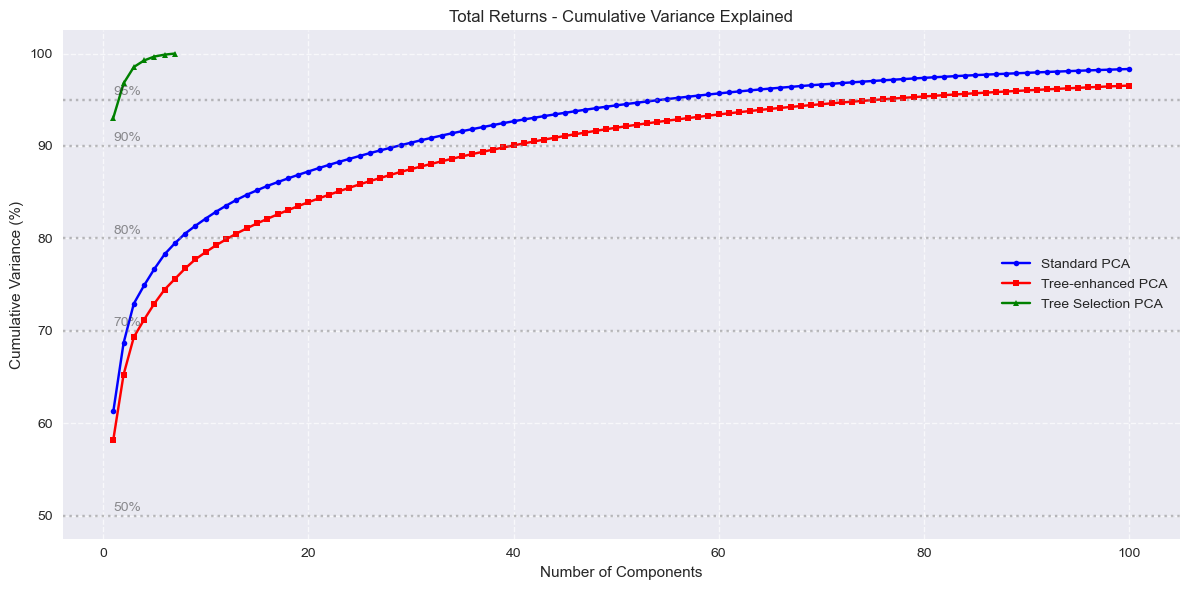

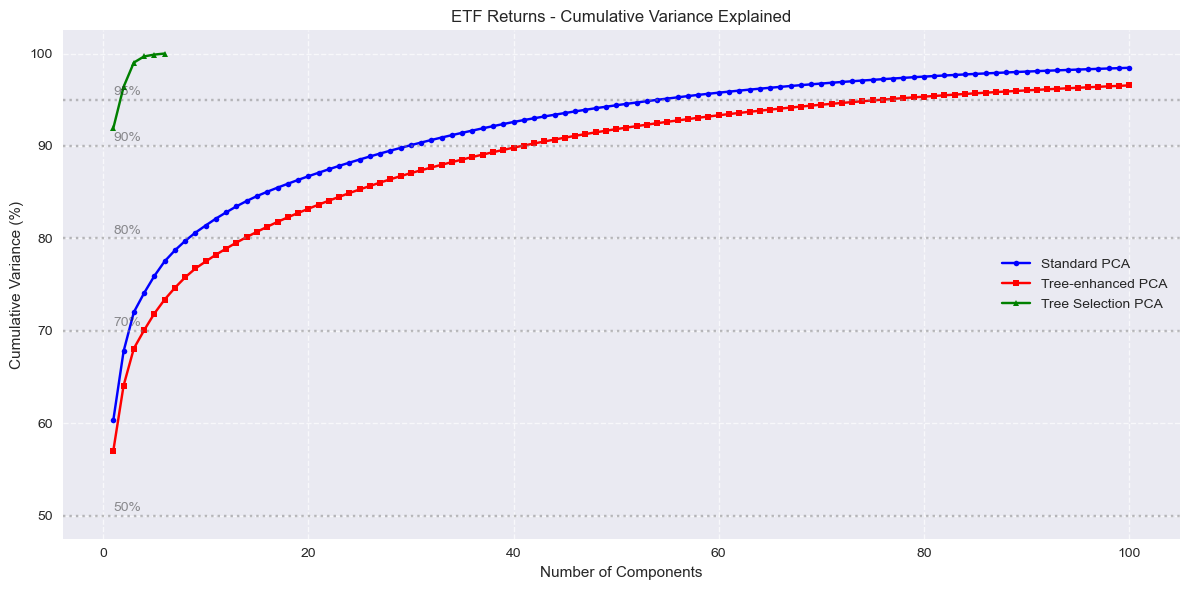

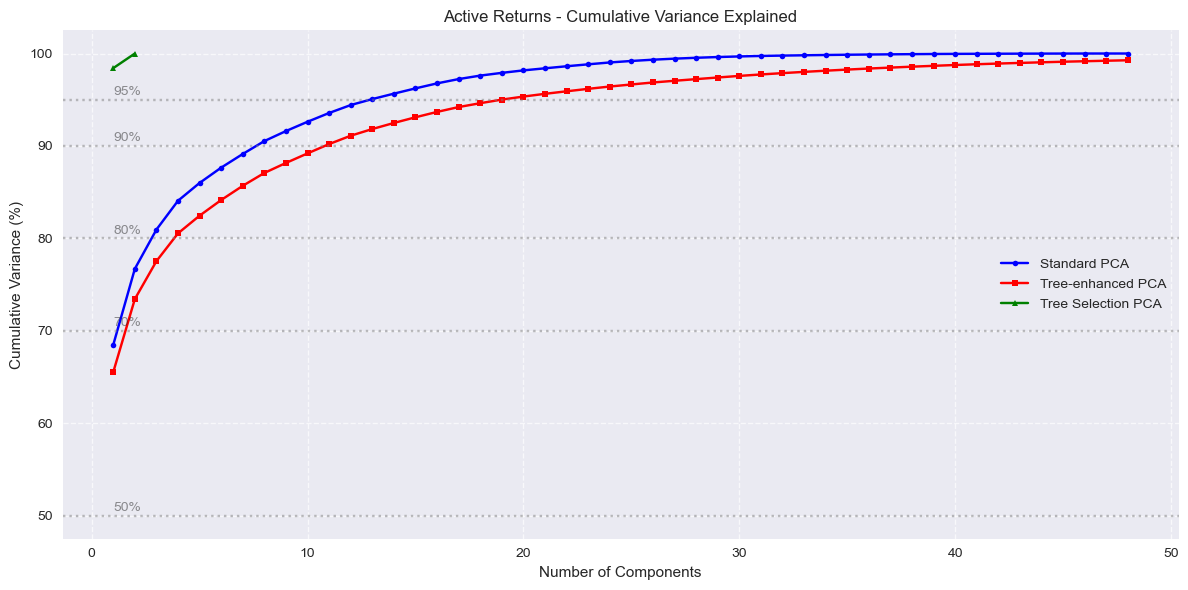

In [16]:
plot_variance_comparison(
    standard_results=returns_results,
    tree_enhanced_results=returns_tree,
    tree_selection_results=returns_selection,
    title="Total Returns"
)
plt.show()

plot_variance_comparison(
    standard_results=etf_results,
    tree_enhanced_results=etf_tree,
    tree_selection_results=etf_selection,
    title="ETF Returns"
)
plt.show()

plot_variance_comparison(
    standard_results=active_results,
    tree_enhanced_results=active_tree,
    tree_selection_results=active_selection,
    title="Active Returns"
)
plt.show()

### 4. Convert to CSV

In [1]:
# 1. Export top 14 factors from standard PCA on total returns
pca1_df = pd.DataFrame(returns_results['pca_result']).iloc[:, :14]
pca1_df.rename(columns={i: f'PC{i+1}' for i in range(pca1_df.shape[1])}, inplace=True)
pca1_df.to_csv('data\pca1.csv', index=True)

# 2. Export top 14 factors from tree-enhanced PCA on total returns
pca2_df = pd.DataFrame(returns_tree['pca_result']).iloc[:, :14]
pca2_df.rename(columns={i: f'PC{i+1}' for i in range(pca2_df.shape[1])}, inplace=True)
pca2_df.to_csv('data\pca2.csv', index=True)

# 3. Export all PCs from tree selection on total returns
pca3_df = pd.DataFrame(returns_selection['pca_result'])
pca3_df.rename(columns={i: f'PC{i+1}' for i in range(pca6_df.shape[1])}, inplace=True)
pca3_df.to_csv('data\pca3.csv', index=True)

# 4. Export top 10 factors from ETF and top 4 from active using standard PCA
pca4_df_etf = pd.DataFrame(etf_results['pca_result']).iloc[:, :10]
pca4_df_etf.rename(columns={i: f'ETF_PC{i+1}' for i in range(pca4_df_etf.shape[1])}, inplace=True)
pca4_df_active = pd.DataFrame(active_results['pca_result']).iloc[:, :4]
pca4_df_active.rename(columns={i: f'Active_PC{i+1}' for i in range(pca4_df_active.shape[1])}, inplace=True)
pca4_df = pd.concat([pca4_df_etf, pca4_df_active], axis=1)
pca4_df.to_csv('data\pca4.csv', index=True)

# 5. Export top 10 factors from ETF and top 4 from active using tree-enhanced PCA
pca5_df_etf = pd.DataFrame(etf_tree['pca_result']).iloc[:, :10]
pca5_df_etf.rename(columns={i: f'ETF_PC{i+1}' for i in range(pca5_df_etf.shape[1])}, inplace=True)
pca5_df_active = pd.DataFrame(active_tree['pca_result']).iloc[:, :4]
pca5_df_active.rename(columns={i: f'Active_PC{i+1}' for i in range(pca5_df_active.shape[1])}, inplace=True)
pca5_df = pd.concat([pca5_df_etf, pca5_df_active], axis=1)
pca5_df.to_csv('data\pca5.csv', index=True)

# 6. Export all ETF PCs plus all active PCs from tree selection
pca6_df_etf = pd.DataFrame(etf_selection['pca_result'])
pca6_df_etf.rename(columns={i: f'ETF_PC{i+1}' for i in range(pca6_df_etf.shape[1])}, inplace=True)
pca6_df_active = pd.DataFrame(active_selection['pca_result'])
pca6_df_active.rename(columns={i: f'Active_PC{i+1}' for i in range(pca6_df_active.shape[1])}, inplace=True)
pca6_df = pd.concat([pca6_df_etf, pca6_df_active], axis=1)
pca6_df.to_csv('data\pca6.csv', index=True)

NameError: name 'pd' is not defined